In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import time

warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=DeprecationWarning)

# Train and test on real data
## Short range
### Filter

In [2]:
# https://api.pharmgkb.org/v1/download/submission/553247439
warfarin = pd.read_excel('PS206767-553247439.xls', sheet_name=1)

In [3]:
warfarin_clean = warfarin.loc[:,
                 [
                     'Gender',
                     'Race (OMB)',
                     'Age',
                     'Height (cm)',
                     'Weight (kg)',

                     'Indication for Warfarin Treatment',
                     'Diabetes',
                     'Congestive Heart Failure and/or Cardiomyopathy',
                     'Valve Replacement',
                     'Aspirin',
                     'Acetaminophen or Paracetamol (Tylenol)',
                     'Was Dose of Acetaminophen or Paracetamol (Tylenol) >1300mg/day',
                     'Simvastatin (Zocor)',
                     'Atorvastatin (Lipitor)',
                     'Fluvastatin (Lescol)',
                     'Lovastatin (Mevacor)',
                     'Pravastatin (Pravachol)',
                     'Rosuvastatin (Crestor)',
                     'Cerivastatin (Baycol)',
                     'Amiodarone (Cordarone)',
                     'Carbamazepine (Tegretol)',
                     'Phenytoin (Dilantin)',
                     'Rifampin or Rifampicin',
                     'Sulfonamide Antibiotics',
                     'Macrolide Antibiotics',
                     'Anti-fungal Azoles',
                     'Herbal Medications, Vitamins, Supplements',
                     'Current Smoker',

                     'VKORC1 -1639 consensus',
                     'VKORC1 497 consensus',
                     'VKORC1 1173 consensus',
                     'VKORC1 1542 consensus',
                     'VKORC1 3730 consensus',
                     'VKORC1 2255 consensus',
                     'VKORC1 -4451 consensus',
                     'CYP2C9 consensus',

                     'Target INR',
                     'Estimated Target INR Range Based on Indication',
                     'Therapeutic Dose of Warfarin', ]]
warfarin_clean = warfarin_clean.dropna(subset=['Height (cm)',
                                               'Weight (kg)',
                                               'Therapeutic Dose of Warfarin', ])

### Transform

In [4]:
data = pd.DataFrame(columns=[
    'Gender',
    'Age in decades',
    'Height (cm)',
    'Weight (kg)',
    'Race Asian',
    'Race Black or African American',
    'Race Caucasian or White',
    'Race Unknown',

    'DVT',
    'PE',
    'Afib/flutter',
    'Heart Valve',
    'Cardiomyopathy/LV Dilation',
    'Stroke',
    'Post-Orthopedic',
    'Other',
    'Diabetes',
    'Congestive Heart Failure and/or Cardiomyopathy',
    'Valve Replacement',

    'Aspirin',
    'Acetaminophen or Paracetamol (Tylenol)',
    'Was Dose of Acetaminophen or Paracetamol (Tylenol) >1300mg/day',
    'Simvastatin (Zocor)',
    'Atorvastatin (Lipitor)',
    'Fluvastatin (Lescol)',
    'Lovastatin (Mevacor)',
    'Pravastatin (Pravachol)',
    'Rosuvastatin (Crestor)',
    'Cerivastatin (Baycol)',
    'Amiodarone (Cordarone)',
    'Carbamazepine (Tegretol)',
    'Phenytoin (Dilantin)',
    'Rifampin or Rifampicin',
    'Sulfonamide Antibiotics',
    'Macrolide Antibiotics',
    'Anti-fungal Azoles',
    'Herbal Medications, Vitamins, Supplements',
    'Current Smoker',

    'CYP2C9 *1',
    'CYP2C9 *2',
    'CYP2C9 *3',
    'CYP2C9 *4',
    'CYP2C9 *5',
    'CYP2C9 *6',
    'CYP2C9 *7',
    'CYP2C9 *8',
    'CYP2C9 *9',
    'CYP2C9 *10',
    'CYP2C9 *11',
    'CYP2C9 *12',
    'CYP2C9 *13',
    'CYP2C9 *14',

    'VKORC1 - -1639G>A',
    'VKORC1 - 497T>G',
    'VKORC1 - 1173C>T',
    'VKORC1 - 1542G>C',
    'VKORC1 - 3730G>A',
    'VKORC1 - 2255C>T',
    'VKORC1 - -4451C>A',

    'Target INR',
    'dose',
    'type'])

### Type detail

- Ngày 1 viên 1mg -> 7mg/tuần
- Ngày 1 viên 2mg hoặc 2 viên 1mg -> 14mg/tuần
- Ngày 1 viên 3mg -> 21mg/tuần
- Ngày 1 viên 4mg hoặc 2 viên 2mg -> 28mg/tuần
- Ngày 1 viên 5mg hoặc 2 viên 2.5mg -> 35mg/tuần
- Ngày 1 viên 6mg hoặc 2 viên 3mg -> 42mg/tuần
- Ngày 1 viên 7.5mg -> 52.5mg/tuần
- Ngày 2 viên 4mg -> 56mg/tuần
- Ngày 2 viên 5mg -> 70mg/tuần
- Ngày 2 viên 6mg -> 84mg/tuần
- Ngày 2 viên 7.5mg -> 105mg/tuần

In [5]:
warfarin_data = []

for index, row in warfarin_clean.iterrows():
    sample = {
        'Gender': 1 if row['Gender'] == 'male' else 0,
        'Age in decades': 0,
        'Height (cm)': row['Height (cm)'],
        'Weight (kg)': row['Weight (kg)'],

        'DVT': 0,
        'PE': 0,
        'Afib/flutter': 0,
        'Heart Valve': 0,
        'Cardiomyopathy/LV Dilation': 0,
        'Stroke': 0,
        'Post-Orthopedic': 0,
        'Other': 0,
        'Diabetes': 0 if pd.isnull(row['Diabetes']) else row['Diabetes'],
        'Congestive Heart Failure and/or Cardiomyopathy': 0 if pd.isnull(row['Congestive Heart Failure and/or Cardiomyopathy']) else row['Congestive Heart Failure and/or Cardiomyopathy'],
        'Valve Replacement': 0 if pd.isnull(row['Valve Replacement']) else row['Valve Replacement'],
        
        'Aspirin': 0 if pd.isnull(row['Aspirin']) else row['Aspirin'],
        'Acetaminophen or Paracetamol (Tylenol)': 0 if pd.isnull(row['Acetaminophen or Paracetamol (Tylenol)']) else row['Acetaminophen or Paracetamol (Tylenol)'],
        'Was Dose of Acetaminophen or Paracetamol (Tylenol) >1300mg/day': 0 if pd.isnull(row['Was Dose of Acetaminophen or Paracetamol (Tylenol) >1300mg/day']) else row['Was Dose of Acetaminophen or Paracetamol (Tylenol) >1300mg/day'],
        'Simvastatin (Zocor)': 0 if pd.isnull(row['Simvastatin (Zocor)']) else row['Simvastatin (Zocor)'],
        'Atorvastatin (Lipitor)': 0 if pd.isnull(row['Atorvastatin (Lipitor)']) else row['Atorvastatin (Lipitor)'],
        'Fluvastatin (Lescol)': 0 if pd.isnull(row['Fluvastatin (Lescol)']) else row['Fluvastatin (Lescol)'],
        'Lovastatin (Mevacor)': 0 if pd.isnull(row['Lovastatin (Mevacor)']) else row['Lovastatin (Mevacor)'],
        'Pravastatin (Pravachol)': 0 if pd.isnull(row['Pravastatin (Pravachol)']) else row['Pravastatin (Pravachol)'],
        'Rosuvastatin (Crestor)': 0 if pd.isnull(row['Rosuvastatin (Crestor)']) else row['Rosuvastatin (Crestor)'],
        'Cerivastatin (Baycol)': 0 if pd.isnull(row['Cerivastatin (Baycol)']) else row['Cerivastatin (Baycol)'],
        'Amiodarone (Cordarone)': 0 if pd.isnull(row['Amiodarone (Cordarone)']) else row['Amiodarone (Cordarone)'],
        'Carbamazepine (Tegretol)': 0 if pd.isnull(row['Carbamazepine (Tegretol)']) else row['Carbamazepine (Tegretol)'],
        'Phenytoin (Dilantin)': 0 if pd.isnull(row['Phenytoin (Dilantin)']) else row['Phenytoin (Dilantin)'],
        'Rifampin or Rifampicin': 0 if pd.isnull(row['Rifampin or Rifampicin']) else row['Rifampin or Rifampicin'],
        'Sulfonamide Antibiotics': 0 if pd.isnull(row['Sulfonamide Antibiotics']) else row['Sulfonamide Antibiotics'],
        'Macrolide Antibiotics': 0 if pd.isnull(row['Macrolide Antibiotics']) else row['Macrolide Antibiotics'],
        'Anti-fungal Azoles': 0 if pd.isnull(row['Anti-fungal Azoles']) else row['Anti-fungal Azoles'],
        'Herbal Medications, Vitamins, Supplements': 0 if pd.isnull(row['Herbal Medications, Vitamins, Supplements']) else row['Herbal Medications, Vitamins, Supplements'],
        'Current Smoker': 0 if pd.isnull(row['Current Smoker']) else row['Current Smoker'],
    
        'Race Asian': 0,
        'Race Black or African American': 0,
        'Race Unknown': 0,
        'Race Caucasian or White': 0,

        'CYP2C9 *1': 0,
        'CYP2C9 *2': 0,
        'CYP2C9 *3': 0,
        'CYP2C9 *4': 0,
        'CYP2C9 *5': 0,
        'CYP2C9 *6': 0,
        'CYP2C9 *7': 0,
        'CYP2C9 *8': 0,
        'CYP2C9 *9': 0,
        'CYP2C9 *10': 0,
        'CYP2C9 *11': 0,
        'CYP2C9 *12': 0,
        'CYP2C9 *13': 0,
        'CYP2C9 *14': 0,
    
        'VKORC1 - -1639G>A': 0,
        'VKORC1 - 497T>G': 0,
        'VKORC1 - 1173C>T': 0,
        'VKORC1 - 1542G>C': 0,
        'VKORC1 - 3730G>A': 0,
        'VKORC1 - 2255C>T': 0,
        'VKORC1 - -4451C>A': 0,

        'Target INR': 0,
        'dose': row['Therapeutic Dose of Warfarin'],
        'type': 0
    }
    try:
        sample['Age in decades'] = int(str(row['Age']).split('-')[0].replace('+', '')) / 10
    except:
        continue

    if pd.isnull(row['Indication for Warfarin Treatment']):
        sample['Other']=1
    else:
        sample['DVT'] = str(row['Indication for Warfarin Treatment']).count('1')
        sample['PE'] = str(row['Indication for Warfarin Treatment']).count('2')
        sample['Afib/flutter'] = str(row['Indication for Warfarin Treatment']).count('3')
        sample['Heart Valve'] = str(row['Indication for Warfarin Treatment']).count('4')
        sample['Cardiomyopathy/LV Dilation'] = str(row['Indication for Warfarin Treatment']).count('5')
        sample['Stroke'] = str(row['Indication for Warfarin Treatment']).count('6')
        sample['Post-Orthopedic'] = str(row['Indication for Warfarin Treatment']).count('7')
        sample['Other'] = str(row['Indication for Warfarin Treatment']).count('8')

    match row['Race (OMB)']:
        case 'White':
            sample['Race Caucasian or White'] = 1
        case 'Asian':
            sample['Race Asian'] = 1
        case 'Black or African American':
            sample['Race Black or African American'] = 1
        case 'Unknown':
            sample['Race Unknown'] = 1

    if pd.isnull(row['VKORC1 -1639 consensus']):
        pass
    else:
        sample['VKORC1 - -1639G>A'] = str(row['VKORC1 -1639 consensus']).count('A')
        
    if pd.isnull(row['VKORC1 497 consensus']):
        pass
    else:
        sample['VKORC1 - 497T>G'] = str(row['VKORC1 497 consensus']).count('G')
        
    if pd.isnull(row['VKORC1 1173 consensus']):
        pass
    else:
        sample['VKORC1 - 1173C>T'] = str(row['VKORC1 1173 consensus']).count('T')
        
    if pd.isnull(row['VKORC1 1542 consensus']):
        pass
    else:
        sample['VKORC1 - 1542G>C'] = str(row['VKORC1 1542 consensus']).count('C')
        
    if pd.isnull(row['VKORC1 3730 consensus']):
        pass
    else:
        sample['VKORC1 - 3730G>A'] = str(row['VKORC1 3730 consensus']).count('A')
        
    if pd.isnull(row['VKORC1 2255 consensus']):
        pass
    else:
        sample['VKORC1 - 2255C>T'] = str(row['VKORC1 2255 consensus']).count('T')
        
    if pd.isnull(row['VKORC1 -4451 consensus']):
        pass
    else:
        sample['VKORC1 - -4451C>A'] = str(row['VKORC1 -4451 consensus']).count('A')

    sample['CYP2C9 *1'] = str(row['CYP2C9 consensus']).count('*1')
    sample['CYP2C9 *2'] = str(row['CYP2C9 consensus']).count('*2')
    sample['CYP2C9 *3'] = str(row['CYP2C9 consensus']).count('*3')
    sample['CYP2C9 *4'] = str(row['CYP2C9 consensus']).count('*4')
    sample['CYP2C9 *5'] = str(row['CYP2C9 consensus']).count('*5')
    sample['CYP2C9 *6'] = str(row['CYP2C9 consensus']).count('*6')
    sample['CYP2C9 *7'] = str(row['CYP2C9 consensus']).count('*7')
    sample['CYP2C9 *8'] = str(row['CYP2C9 consensus']).count('*8')
    sample['CYP2C9 *9'] = str(row['CYP2C9 consensus']).count('*9')
    sample['CYP2C9 *10'] = str(row['CYP2C9 consensus']).count('*10')
    sample['CYP2C9 *11'] = str(row['CYP2C9 consensus']).count('*11')
    sample['CYP2C9 *12'] = str(row['CYP2C9 consensus']).count('*12')
    sample['CYP2C9 *13'] = str(row['CYP2C9 consensus']).count('*13')
    sample['CYP2C9 *14'] = str(row['CYP2C9 consensus']).count('*14')

    if not pd.isnull(row['Target INR']):
        sample['Target INR'] = row['Target INR']
    else:
        if not pd.isnull(row['Estimated Target INR Range Based on Indication']):
            sample['Target INR'] = float(str(row['Estimated Target INR Range Based on Indication']).split('-')[1])
        else:
            continue
    
    if sample['dose'] < 7:
        sample['type'] = 0
    elif 7 <= sample['dose'] < 14:
        sample['type'] = 1
    elif 14 <= sample['dose'] < 21:
        sample['type'] = 2
    elif 21 <= sample['dose'] < 28:
        sample['type'] = 3
    elif 28 <= sample['dose'] < 35:
        sample['type'] = 4
    elif 35 <= sample['dose'] < 42:
        sample['type'] = 5
    elif 42 <= sample['dose'] < 52.5:
        sample['type'] = 6
    elif 52.5 <= sample['dose'] < 56:
        sample['type'] = 7
    elif 56 <= sample['dose'] < 70:
        sample['type'] = 8
    elif 70 <= sample['dose'] < 84:
        sample['type'] = 9
    elif 84 <= sample['dose'] < 105:
        sample['type'] = 10
    else:
        sample['type'] = 11
    warfarin_data.append(sample)

data = data._append(warfarin_data, ignore_index=True)

In [6]:
data.shape

(3663, 62)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3663 entries, 0 to 3662
Data columns (total 62 columns):
 #   Column                                                          Non-Null Count  Dtype  
---  ------                                                          --------------  -----  
 0   Gender                                                          3663 non-null   object 
 1   Age in decades                                                  3663 non-null   float64
 2   Height (cm)                                                     3663 non-null   float64
 3   Weight (kg)                                                     3663 non-null   float64
 4   Race Asian                                                      3663 non-null   object 
 5   Race Black or African American                                  3663 non-null   object 
 6   Race Caucasian or White                                         3663 non-null   object 
 7   Race Unknown                                       

### split

In [8]:
data_size = len(data)
ratio = 0.7
pointer = int(ratio * data_size)
train_set = data.iloc[:pointer, :-2]
test_set = data.iloc[pointer:, :-2]
train_dose = data.iloc[:pointer, -1:].values
test_dose = data.iloc[pointer:, -1:].values

### train

In [9]:
arms = np.arange(12)
accuracy = []
A_map = {}
b_map = {}
for arm in arms:
    A_map[arm] = np.identity(len(list(train_set)))
    b_map[arm] = np.zeros(len(list(train_set)))

for epoch in range(200):
    start_time = time.time()
    # train
    indices = np.random.permutation(list(range(len(train_set))))
    for i in indices:
        feature = np.array(train_set.iloc[i], dtype=float)
        # iterate through actions
        p = {}
        max_value = -np.inf
        max_arm = 0
        for arm in arms:
            theta = np.matmul(np.linalg.inv(A_map[arm]), b_map[arm])
            p = np.matmul(theta.T, feature) + \
                np.sqrt(np.matmul(np.matmul(feature.T, np.linalg.inv(A_map[arm])), feature))

            if p == max_value:
                if np.random.choice(a=[False, True]): max_arm = arm
            elif p > max_value:
                max_value = p
                max_arm = arm

        # observe reward and update A and b
        r = 0 if max_arm == train_dose[i] else -1
        A_map[max_arm] += np.outer(feature, feature)
        b_map[max_arm] += r * feature

    # test
    correct_count = 0
    count = 0
    higher = 0
    lower = 0
    for i in range(len(test_set)):
        count += 1
        feature = np.array(test_set.iloc[i], dtype=float)
        # iterate through actions
        p = {}
        max_value = -np.inf
        max_arm = 0
        for arm in arms:
            theta = np.matmul(np.linalg.inv(A_map[arm]), b_map[arm])
            p = np.matmul(theta.T, feature) + \
                np.sqrt(np.matmul(np.matmul(feature.T, np.linalg.inv(A_map[arm])), feature))
            if p == max_value:
                if np.random.choice(a=[False, True]): max_arm = arm
            elif p > max_value:
                max_value = p
                max_arm = arm

        if max_arm == test_dose[i]:
            correct_count += 1
        elif max_arm < test_dose[i]:
            lower += test_dose[i] - max_arm
        else:
            higher += max_arm - test_dose[i]

    end_time = time.time()
    accu = correct_count / count
    print("Epoch %d: Accuracy: %.5f%% (%d/%d), Higher: %d, Lower: %d, Time: %.5fs" % (
        epoch, accu * 100, correct_count, count, higher, lower, end_time - start_time))
    accuracy.append(accu)

Epoch 0: Accuracy: 11.46497% (126/1099), Higher: 2212, Lower: 843, Time: 7.25577s
Epoch 1: Accuracy: 14.10373% (155/1099), Higher: 1893, Lower: 842, Time: 6.89788s
Epoch 2: Accuracy: 14.28571% (157/1099), Higher: 1679, Lower: 947, Time: 6.80336s
Epoch 3: Accuracy: 13.73976% (151/1099), Higher: 1707, Lower: 895, Time: 6.82055s
Epoch 4: Accuracy: 13.55778% (149/1099), Higher: 1777, Lower: 919, Time: 6.81065s
Epoch 5: Accuracy: 13.37580% (147/1099), Higher: 1791, Lower: 904, Time: 6.80989s
Epoch 6: Accuracy: 14.37671% (158/1099), Higher: 1723, Lower: 877, Time: 6.87043s
Epoch 7: Accuracy: 14.01274% (154/1099), Higher: 1754, Lower: 884, Time: 6.85291s
Epoch 8: Accuracy: 14.46770% (159/1099), Higher: 1719, Lower: 882, Time: 6.86269s
Epoch 9: Accuracy: 14.37671% (158/1099), Higher: 1719, Lower: 916, Time: 6.84729s
Epoch 10: Accuracy: 14.46770% (159/1099), Higher: 1720, Lower: 887, Time: 6.84722s
Epoch 11: Accuracy: 14.64968% (161/1099), Higher: 1715, Lower: 899, Time: 6.87273s
Epoch 12: Accu

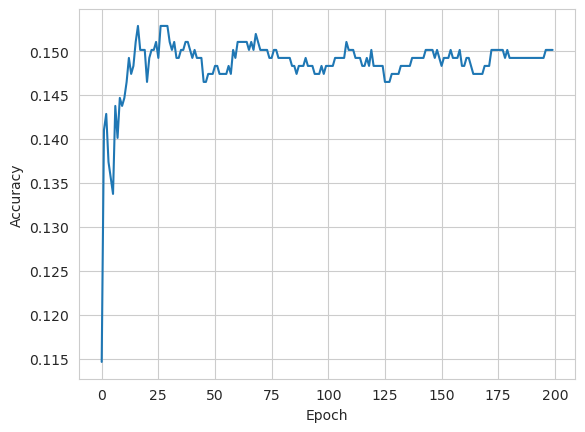

In [10]:
plt.plot(accuracy)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### validate

In [11]:
val_set = data.iloc[:, :-2]
val_dose = data.iloc[:, -1:].values

In [12]:
arms = np.arange(12)
correct_count = 0
count = 0
heatmap = np.zeros((12, 12))

for i in range(len(data)):
    count += 1
    feature = np.array(val_set.iloc[i], dtype=float)
    # iterate through actions
    p = {}
    max_value = -np.inf
    max_arm = 0
    for arm in arms:
        theta = np.matmul(np.linalg.inv(A_map[arm]), b_map[arm])
        p = np.matmul(theta.T, feature) + \
            np.sqrt(np.matmul(np.matmul(feature.T, np.linalg.inv(A_map[arm])), feature))
        if p == max_value:
            if np.random.choice(a=[False, True]): max_arm = arm
        elif p > max_value:
            max_value = p
            max_arm = arm

    if max_arm == val_dose[i][0]:
        correct_count += 1
    heatmap[max_arm][int(val_dose[i][0])] += 1

accu = correct_count / count
print("Validate: Accuracy: %.5f%% (%d/%d)" % (accu * 100, correct_count, count))

Validate: Accuracy: 27.49113% (1007/3663)


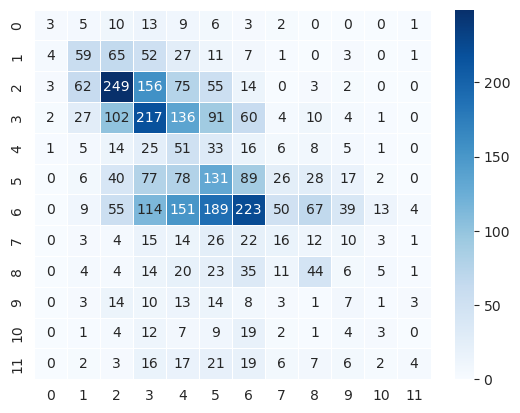

In [13]:
ax = sns.heatmap(heatmap, linewidth=0.5, annot=True, cmap='Blues', fmt='.20g')
plt.show()

## Long range
### Filter

In [14]:
data1 = data.copy()
data1.loc[data1['dose'] < 21,'type'] = 0
data1.loc[(data1['dose'] >= 21) & (data1['dose'] < 49),'type'] = 1
data1.loc[data1['dose'] >= 49,'type'] = 2

### Split

In [15]:
data_size1 = len(data1)
ratio1 = 0.7
pointer = int(ratio1 * data_size1)
train_set1 = data1.iloc[:pointer, :-2]
test_set1 = data1.iloc[pointer:, :-2]
train_dose1 = data1.iloc[:pointer, -1:].values
test_dose1 = data1.iloc[pointer:, -1:].values

### Train

In [16]:
arms = np.arange(3)
accuracy1 = []
A_map1 = {}
b_map1 = {}
for arm in arms:
    A_map1[arm] = np.identity(len(list(train_set1)))
    b_map1[arm] = np.zeros(len(list(train_set1)))

for epoch in range(200):
    start_time = time.time()
    # train
    indices = np.random.permutation(list(range(len(train_set1))))
    for i in indices:
        feature = np.array(train_set1.iloc[i], dtype=float)
        # iterate through actions
        p = {}
        max_value = -np.inf
        max_arm = 0
        for arm in arms:
            theta = np.matmul(np.linalg.inv(A_map1[arm]), b_map1[arm])
            p = np.matmul(theta.T, feature) + \
                np.sqrt(np.matmul(np.matmul(feature.T, np.linalg.inv(A_map1[arm])), feature))

            if p == max_value:
                if np.random.choice(a=[False, True]): max_arm = arm
            elif p > max_value:
                max_value = p
                max_arm = arm

        # observe reward and update A and b
        r = 0 if max_arm == train_dose1[i] else -1
        A_map1[max_arm] += np.outer(feature, feature)
        b_map1[max_arm] += r * feature

    # test
    correct_count = 0
    count = 0
    higher = 0
    lower = 0
    for i in range(len(test_set1)):
        count += 1
        feature = np.array(test_set1.iloc[i], dtype=float)
        # iterate through actions
        p = {}
        max_value = -np.inf
        max_arm = 0
        for arm in arms:
            theta = np.matmul(np.linalg.inv(A_map1[arm]), b_map1[arm])
            p = np.matmul(theta.T, feature) + \
                np.sqrt(np.matmul(np.matmul(feature.T, np.linalg.inv(A_map1[arm])), feature))
            if p == max_value:
                if np.random.choice(a=[False, True]): max_arm = arm
            elif p > max_value:
                max_value = p
                max_arm = arm

        if max_arm == test_dose1[i]:
            correct_count += 1
        elif max_arm < test_dose1[i]:
            lower += test_dose1[i] - max_arm
        else:
            higher += max_arm - test_dose1[i]

    end_time = time.time()
    accu = correct_count / count
    print("Epoch %d: Accuracy: %.5f%% (%d/%d), Higher: %d, Lower: %d, Time: %.5fs" % (
        epoch, accu * 100, correct_count, count, higher, lower, end_time - start_time))
    accuracy1.append(accu)

Epoch 0: Accuracy: 63.33030% (696/1099), Higher: 207, Lower: 208, Time: 2.21031s
Epoch 1: Accuracy: 63.69427% (700/1099), Higher: 208, Lower: 199, Time: 2.14193s
Epoch 2: Accuracy: 64.33121% (707/1099), Higher: 208, Lower: 192, Time: 2.11584s
Epoch 3: Accuracy: 64.33121% (707/1099), Higher: 207, Lower: 192, Time: 2.11556s
Epoch 4: Accuracy: 64.51319% (709/1099), Higher: 207, Lower: 190, Time: 2.09952s
Epoch 5: Accuracy: 64.78617% (712/1099), Higher: 201, Lower: 193, Time: 2.10720s
Epoch 6: Accuracy: 65.15014% (716/1099), Higher: 197, Lower: 193, Time: 2.11448s
Epoch 7: Accuracy: 65.42311% (719/1099), Higher: 196, Lower: 191, Time: 2.12937s
Epoch 8: Accuracy: 65.51410% (720/1099), Higher: 194, Lower: 192, Time: 2.12413s
Epoch 9: Accuracy: 64.87716% (713/1099), Higher: 201, Lower: 191, Time: 2.13358s
Epoch 10: Accuracy: 65.15014% (716/1099), Higher: 197, Lower: 192, Time: 2.12494s
Epoch 11: Accuracy: 65.05914% (715/1099), Higher: 198, Lower: 192, Time: 2.12493s
Epoch 12: Accuracy: 65.332

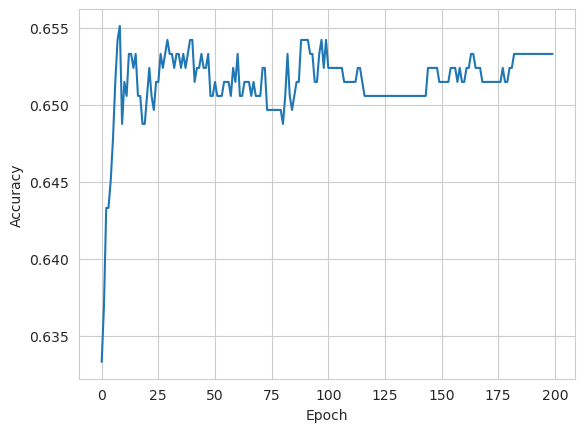

In [17]:
plt.plot(accuracy1)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Validate

In [18]:
val_set1 = data1.iloc[:, :-2]
val_dose1 = data1.iloc[:, -1:].values

In [19]:
arms = np.arange(3)
correct_count = 0
count = 0
heatmap1 = np.zeros((3, 3))

for i in range(len(data1)):
    count += 1
    feature = np.array(val_set1.iloc[i], dtype=float)
    # iterate through actions
    p = {}
    max_value = -np.inf
    max_arm = 0
    for arm in arms:
        theta = np.matmul(np.linalg.inv(A_map1[arm]), b_map1[arm])
        p = np.matmul(theta.T, feature) + \
            np.sqrt(np.matmul(np.matmul(feature.T, np.linalg.inv(A_map1[arm])), feature))
        if p == max_value:
            if np.random.choice(a=[False, True]): max_arm = arm
        elif p > max_value:
            max_value = p
            max_arm = arm

    if max_arm == val_dose1[i][0]:
        correct_count += 1
    heatmap1[max_arm][int(val_dose1[i][0])] += 1

accu = correct_count / count
print("Validate: Accuracy: %.5f%% (%d/%d)" % (accu * 100, correct_count, count))

Validate: Accuracy: 71.30767% (2612/3663)


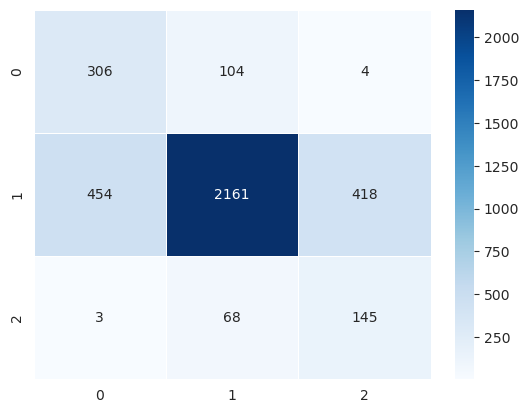

In [20]:
ax = sns.heatmap(heatmap1, linewidth=0.5, annot=True, cmap='Blues', fmt='.20g')
plt.show()

# Train and test on real data with threshold
## Short range
### Filter

In [21]:
data2 = data.drop(data.columns[data.sum() < data_size*0.05], axis=1)
data2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3663 entries, 0 to 3662
Data columns (total 36 columns):
 #   Column                                          Non-Null Count  Dtype  
---  ------                                          --------------  -----  
 0   Gender                                          3663 non-null   object 
 1   Age in decades                                  3663 non-null   float64
 2   Height (cm)                                     3663 non-null   float64
 3   Weight (kg)                                     3663 non-null   float64
 4   Race Asian                                      3663 non-null   object 
 5   Race Black or African American                  3663 non-null   object 
 6   Race Caucasian or White                         3663 non-null   object 
 7   Race Unknown                                    3663 non-null   object 
 8   DVT                                             3663 non-null   object 
 9   PE                                       

### Split

In [22]:
data_size2 = len(data2)
ratio2 = 0.7
pointer = int(ratio2 * data_size2)
train_set2 = data2.iloc[:pointer, :-2]
test_set2 = data2.iloc[pointer:, :-2]
train_dose2 = data2.iloc[:pointer, -1:].values
test_dose2 = data2.iloc[pointer:, -1:].values

### Train

In [23]:
arms = np.arange(12)
accuracy2 = []
A_map2 = {}
b_map2 = {}
for arm in arms:
    A_map2[arm] = np.identity(len(list(train_set2)))
    b_map2[arm] = np.zeros(len(list(train_set2)))

for epoch in range(200):
    start_time = time.time()
    # train
    indices = np.random.permutation(list(range(len(train_set2))))
    for i in indices:
        feature = np.array(train_set2.iloc[i], dtype=float)
        # iterate through actions
        p = {}
        max_value = -np.inf
        max_arm = 0
        for arm in arms:
            theta = np.matmul(np.linalg.inv(A_map2[arm]), b_map2[arm])
            p = np.matmul(theta.T, feature) + \
                np.sqrt(np.matmul(np.matmul(feature.T, np.linalg.inv(A_map2[arm])), feature))

            if p == max_value:
                if np.random.choice(a=[False, True]): max_arm = arm
            elif p > max_value:
                max_value = p
                max_arm = arm

        # observe reward and update A and b
        r = 0 if max_arm == train_dose2[i] else -1
        A_map2[max_arm] += np.outer(feature, feature)
        b_map2[max_arm] += r * feature

    # test
    correct_count = 0
    count = 0
    higher = 0
    lower = 0
    for i in range(len(test_set2)):
        count += 1
        feature = np.array(test_set2.iloc[i], dtype=float)
        # iterate through actions
        p = {}
        max_value = -np.inf
        max_arm = 0
        for arm in arms:
            theta = np.matmul(np.linalg.inv(A_map2[arm]), b_map2[arm])
            p = np.matmul(theta.T, feature) + \
                np.sqrt(np.matmul(np.matmul(feature.T, np.linalg.inv(A_map2[arm])), feature))
            if p == max_value:
                if np.random.choice(a=[False, True]): max_arm = arm
            elif p > max_value:
                max_value = p
                max_arm = arm

        if max_arm == test_dose2[i]:
            correct_count += 1
        elif max_arm < test_dose2[i]:
            lower += test_dose2[i] - max_arm
        else:
            higher += max_arm - test_dose2[i]

    end_time = time.time()
    accu = correct_count / count
    print("Epoch %d: Accuracy: %.5f%% (%d/%d), Higher: %d, Lower: %d, Time: %.5fs" % (
        epoch, accu * 100, correct_count, count, higher, lower, end_time - start_time))
    accuracy2.append(accu)

Epoch 0: Accuracy: 13.01183% (143/1099), Higher: 1426, Lower: 1197, Time: 2.88632s
Epoch 1: Accuracy: 14.46770% (159/1099), Higher: 1659, Lower: 975, Time: 2.87996s
Epoch 2: Accuracy: 15.19563% (167/1099), Higher: 1376, Lower: 1131, Time: 2.96689s
Epoch 3: Accuracy: 16.10555% (177/1099), Higher: 1469, Lower: 979, Time: 2.83909s
Epoch 4: Accuracy: 16.37853% (180/1099), Higher: 1427, Lower: 920, Time: 2.99361s
Epoch 5: Accuracy: 16.37853% (180/1099), Higher: 1539, Lower: 838, Time: 2.85809s
Epoch 6: Accuracy: 16.28753% (179/1099), Higher: 1474, Lower: 850, Time: 2.85255s
Epoch 7: Accuracy: 16.28753% (179/1099), Higher: 1498, Lower: 802, Time: 2.91649s
Epoch 8: Accuracy: 16.46952% (181/1099), Higher: 1471, Lower: 829, Time: 2.86373s
Epoch 9: Accuracy: 16.74249% (184/1099), Higher: 1474, Lower: 816, Time: 2.84726s
Epoch 10: Accuracy: 16.74249% (184/1099), Higher: 1467, Lower: 810, Time: 2.87281s
Epoch 11: Accuracy: 16.92448% (186/1099), Higher: 1448, Lower: 786, Time: 2.94612s
Epoch 12: Ac

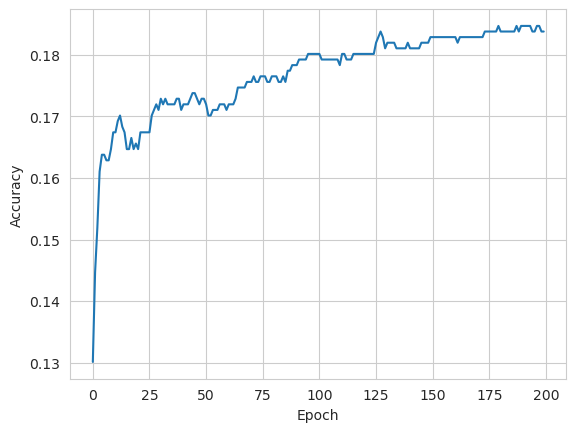

In [24]:
plt.plot(accuracy2)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Validate

In [25]:
val_set2 = data2.iloc[:, :-2]
val_dose2 = data2.iloc[:, -1:].values

In [26]:
arms = np.arange(12)
correct_count = 0
count = 0
heatmap2 = np.zeros((12, 12))

for i in range(len(data2)):
    count += 1
    feature = np.array(val_set2.iloc[i], dtype=float)
    # iterate through actions
    p = {}
    max_value = -np.inf
    max_arm = 0
    for arm in arms:
        theta = np.matmul(np.linalg.inv(A_map2[arm]), b_map2[arm])
        p = np.matmul(theta.T, feature) + \
            np.sqrt(np.matmul(np.matmul(feature.T, np.linalg.inv(A_map2[arm])), feature))
        if p == max_value:
            if np.random.choice(a=[False, True]): max_arm = arm
        elif p > max_value:
            max_value = p
            max_arm = arm

    if max_arm == val_dose2[i][0]:
        correct_count += 1
    heatmap2[max_arm][int(val_dose2[i][0])] += 1

accu = correct_count / count
print("Validate: Accuracy: %.5f%% (%d/%d)" % (accu * 100, correct_count, count))

Validate: Accuracy: 27.60033% (1011/3663)


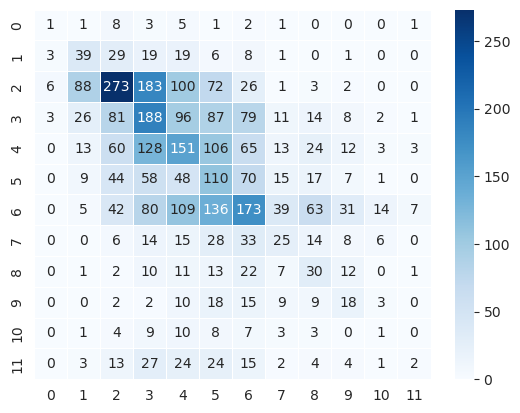

In [27]:
ax = sns.heatmap(heatmap2, linewidth=0.5, annot=True, cmap='Blues', fmt='.20g')
plt.show()

## Long range
### Filter

In [28]:
data3 = data2.copy()
data3.loc[data3['dose'] < 21,'type'] = 0
data3.loc[(data3['dose'] >= 21) & (data3['dose'] < 49),'type'] = 1
data3.loc[data3['dose'] >= 49,'type'] = 2


### Split

In [29]:
data_size3 = len(data3)
ratio3 = 0.7
pointer = int(ratio3 * data_size3)
train_set3 = data3.iloc[:pointer, :-2]
test_set3 = data3.iloc[pointer:, :-2]
train_dose3 = data3.iloc[:pointer, -1:].values
test_dose3 = data3.iloc[pointer:, -1:].values

### Train

In [30]:
arms = np.arange(3)
accuracy3 = []
A_map3 = {}
b_map3 = {}
for arm in arms:
    A_map3[arm] = np.identity(len(list(train_set3)))
    b_map3[arm] = np.zeros(len(list(train_set3)))

for epoch in range(200):
    start_time = time.time()
    # train
    indices = np.random.permutation(list(range(len(train_set3))))
    for i in indices:
        feature = np.array(train_set3.iloc[i], dtype=float)
        # iterate through actions
        p = {}
        max_value = -np.inf
        max_arm = 0
        for arm in arms:
            theta = np.matmul(np.linalg.inv(A_map3[arm]), b_map3[arm])
            p = np.matmul(theta.T, feature) + \
                np.sqrt(np.matmul(np.matmul(feature.T, np.linalg.inv(A_map3[arm])), feature))

            if p == max_value:
                if np.random.choice(a=[False, True]): max_arm = arm
            elif p > max_value:
                max_value = p
                max_arm = arm

        # observe reward and update A and b
        r = 0 if max_arm == train_dose3[i] else -1
        A_map3[max_arm] += np.outer(feature, feature)
        b_map3[max_arm] += r * feature

    # test
    correct_count = 0
    count = 0
    higher = 0
    lower = 0
    for i in range(len(test_set3)):
        count += 1
        feature = np.array(test_set3.iloc[i], dtype=float)
        # iterate through actions
        p = {}
        max_value = -np.inf
        max_arm = 0
        for arm in arms:
            theta = np.matmul(np.linalg.inv(A_map3[arm]), b_map3[arm])
            p = np.matmul(theta.T, feature) + \
                np.sqrt(np.matmul(np.matmul(feature.T, np.linalg.inv(A_map3[arm])), feature))
            if p == max_value:
                if np.random.choice(a=[False, True]): max_arm = arm
            elif p > max_value:
                max_value = p
                max_arm = arm

        if max_arm == test_dose3[i]:
            correct_count += 1
        elif max_arm < test_dose3[i]:
            lower += test_dose3[i] - max_arm
        else:
            higher += max_arm - test_dose3[i]

    end_time = time.time()
    accu = correct_count / count
    print("Epoch %d: Accuracy: %.5f%% (%d/%d), Higher: %d, Lower: %d, Time: %.5fs" % (
        epoch, accu * 100, correct_count, count, higher, lower, end_time - start_time))
    accuracy3.append(accu)

Epoch 0: Accuracy: 63.05732% (693/1099), Higher: 236, Lower: 182, Time: 1.03681s
Epoch 1: Accuracy: 64.24022% (706/1099), Higher: 223, Lower: 180, Time: 1.02010s
Epoch 2: Accuracy: 64.05823% (704/1099), Higher: 223, Lower: 181, Time: 1.05669s
Epoch 3: Accuracy: 64.69518% (711/1099), Higher: 214, Lower: 182, Time: 1.07590s
Epoch 4: Accuracy: 65.05914% (715/1099), Higher: 208, Lower: 184, Time: 1.04765s
Epoch 5: Accuracy: 64.87716% (713/1099), Higher: 210, Lower: 184, Time: 1.03699s
Epoch 6: Accuracy: 64.87716% (713/1099), Higher: 206, Lower: 187, Time: 1.01119s
Epoch 7: Accuracy: 64.60419% (710/1099), Higher: 208, Lower: 188, Time: 1.01578s
Epoch 8: Accuracy: 64.69518% (711/1099), Higher: 204, Lower: 190, Time: 1.02543s
Epoch 9: Accuracy: 65.42311% (719/1099), Higher: 197, Lower: 189, Time: 1.02240s
Epoch 10: Accuracy: 65.33212% (718/1099), Higher: 198, Lower: 189, Time: 1.05988s
Epoch 11: Accuracy: 65.15014% (716/1099), Higher: 197, Lower: 192, Time: 1.09682s
Epoch 12: Accuracy: 64.968

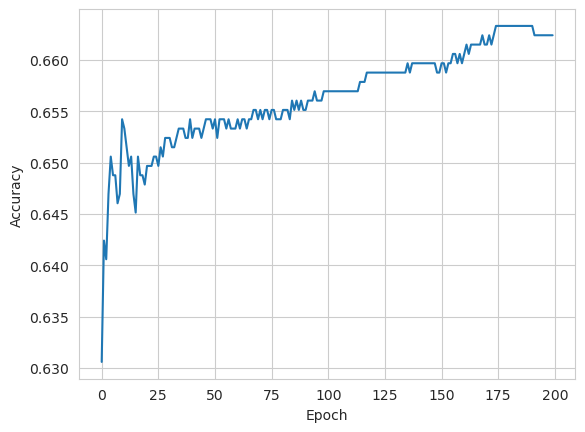

In [31]:
plt.plot(accuracy3)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.show()

### Validate

In [32]:
val_set3 = data3.iloc[:, :-2]
val_dose3 = data3.iloc[:, -1:].values

In [33]:
arms = np.arange(3)
correct_count = 0
count = 0
heatmap3 = np.zeros((3, 3))

for i in range(len(data3)):
    count += 1
    feature = np.array(val_set3.iloc[i], dtype=float)
    # iterate through actions
    p = {}
    max_value = -np.inf
    max_arm = 0
    for arm in arms:
        theta = np.matmul(np.linalg.inv(A_map3[arm]), b_map3[arm])
        p = np.matmul(theta.T, feature) + \
            np.sqrt(np.matmul(np.matmul(feature.T, np.linalg.inv(A_map3[arm])), feature))
        if p == max_value:
            if np.random.choice(a=[False, True]): max_arm = arm
        elif p > max_value:
            max_value = p
            max_arm = arm

    if max_arm == val_dose3[i][0]:
        correct_count += 1
    heatmap3[max_arm][int(val_dose3[i][0])] += 1

accu = correct_count / count
print("Validate: Accuracy: %.5f%% (%d/%d)" % (accu * 100, correct_count, count))

Validate: Accuracy: 71.00737% (2601/3663)


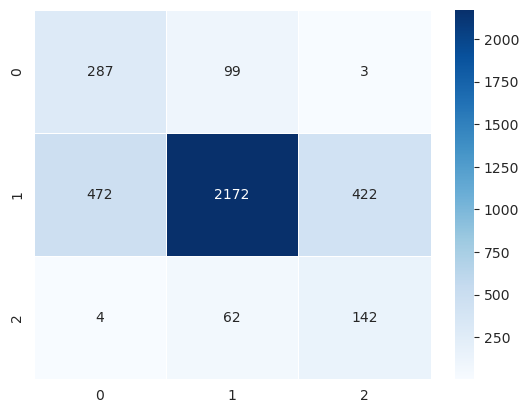

In [34]:
ax = sns.heatmap(heatmap3, linewidth=0.5, annot=True, cmap='Blues', fmt='.20g')
plt.show()